In [19]:
%load_ext autoreload
%autoreload 2

In [20]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import *
from pathlib import Path

In [21]:
DATADIR = "data/bms-molecular-translation"
!ls {DATADIR}

sample_submission.csv  test  train  train_labels.csv


In [22]:
traindf = pd.read_csv(f"{DATADIR}/train_labels.csv")
print(f"df size = {traindf.shape}")
traindf.sample(5)

df size = (2424186, 2)


,image_id,InChI
1540416,a29cfd720594,InChI=1S/C15H20BrNO3/c1-10-5-6-17(14(7-10)15(1...
1217387,80752c32e4e5,InChI=1S/C23H26N2O5/c1-14(2)21(22(27)29-3)25-2...
2068049,da4547cc9b08,InChI=1S/C7H8N4/c1-7(2)10-3-5-6(11-7)9-4-8-5/h...
262268,1b9743414f27,InChI=1S/C21H21N5O2/c1-14-12-18(27)26-19(16-6-...
1219016,80a167b74dd2,InChI=1S/C15H21N5O/c1-4-16-12-6-7-17-13(8-12)1...


In [23]:
train_imgpaths = Path(f"{DATADIR}/train").rglob('*.*')

In [24]:
imgpath = next(train_imgpaths)
traindf[traindf.image_id == imgpath.stem]["InChI"].values[0]

'InChI=1S/C22H22ClNO3/c23-19-9-5-4-8-16(19)17-14-18(17)20(25)24-12-10-22(11-13-24,21(26)27)15-6-2-1-3-7-15/h1-9,17-18H,10-14H2,(H,26,27)'

(263, 477)


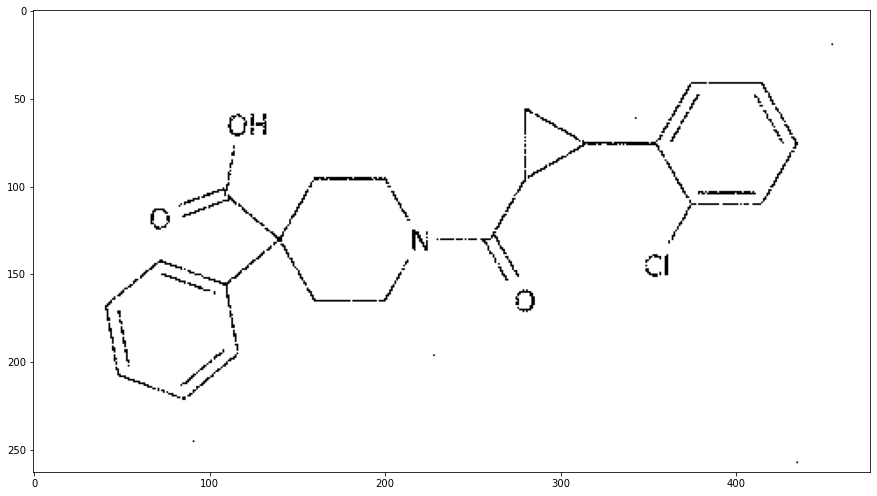

In [25]:
img = plt.imread(imgpath)
print(img.shape)
plt.figure(figsize=(15,10))
plt.imshow(img, cmap='gray')

# InChI to Molecule

In [26]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

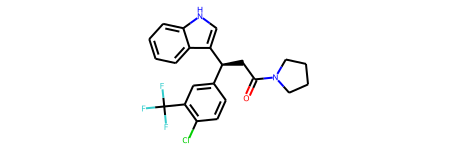

In [40]:
imgpath = next(train_imgpaths)
inchi_string = traindf[traindf.image_id == imgpath.stem]["InChI"].values[0]
chem_obj = Chem.MolFromInchi(inchi_string)
chem_obj

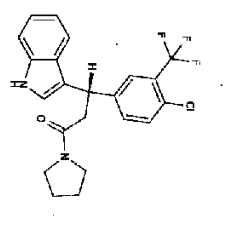

In [41]:
img = plt.imread(imgpath)
plt.imshow(255-preprocess_image(img), cmap='gray')
plt.axis('off');

In [48]:
oimg = np.array(Draw.MolToImage(chem_obj))

In [53]:
# Draw.MolToImage(chem_obj).save("test.png")

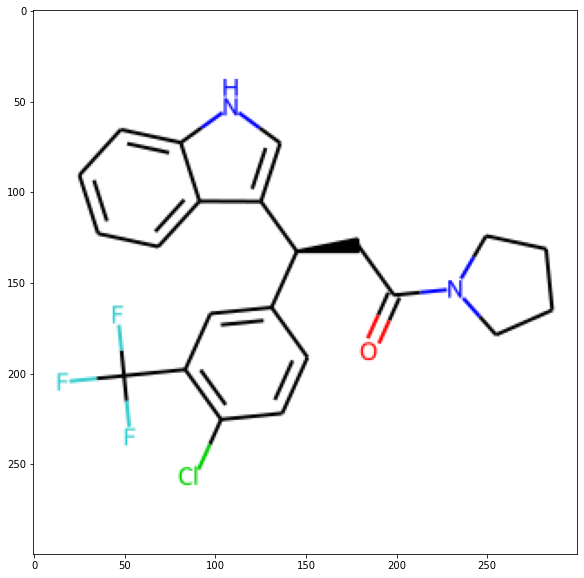

In [49]:
plt.figure(figsize=(15,10))
plt.imshow(oimg, cmap='gray')

In [46]:
def mol_with_atom_index(mol):
    """https://www.kaggle.com/sapr3s/inchi-samples"""
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(atom.GetIdx()+1)
    return mol

def mol_with_hybridization(mol):
    for i, atom in enumerate(mol.GetAtoms()):
        count_hydrogens = atom.GetTotalNumHs()
        if count_hydrogens==0:
            lbl = '%s'%(atom.GetSymbol())
#         elif count_hydrogens==1:
#             lbl = '%sH'%(atom.GetSymbol())
        else:
            lbl = '%sH%s'%(atom.GetSymbol(),count_hydrogens)
        atom.SetProp('atomLabel',lbl)
    return mol

def show_img(inchi, d=True):
    mol = Chem.MolFromInchi(inchi)
    display(mol)
    if d:
        display(mol_with_atom_index(mol))
        display(mol_with_hybridization(mol))

InChI=1S/C17H17FN4O2S2/c1-12-9-15-16(19-11-20-17(15)25-12)21-5-7-22(8-6-21)26(23,24)14-4-2-3-13(18)10-14/h2-4,9-11H,5-8H2,1H3


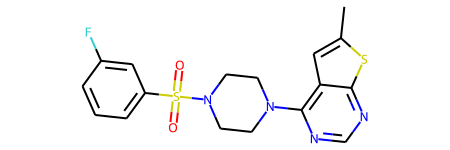

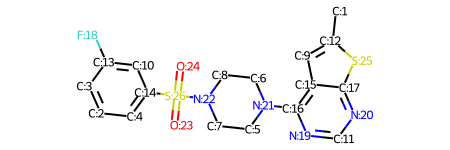

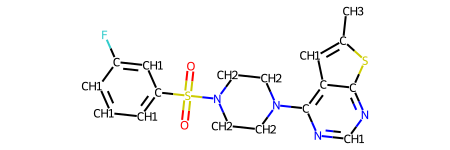

In [47]:
imgpath = next(train_imgpaths)
inchi_string = traindf[traindf.image_id == imgpath.stem]["InChI"].values[0]
print(inchi_string)
show_img(inchi_string)

(256, 256)


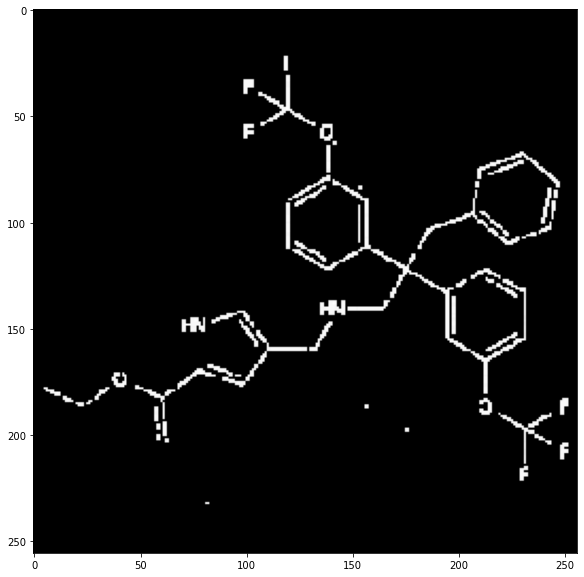

In [15]:
img = plt.imread(imgpath)
plt.figure(figsize=(15,10))
oimg = preprocess_image(img)
print(oimg.shape)
plt.imshow(oimg, cmap='gray')

## Line detection

In [93]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from preprocessing import preprocess_image
from scipy import ndimage, misc

In [55]:
img = plt.imread("test.png")
img.shape

(300, 300, 3)

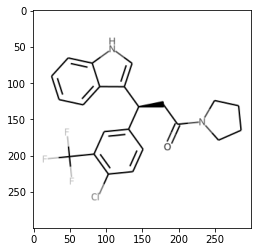

In [56]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), cmap='gray')

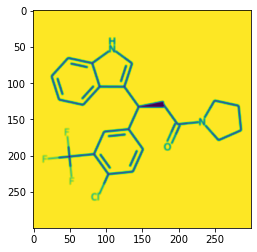

In [109]:
plt.imshow()

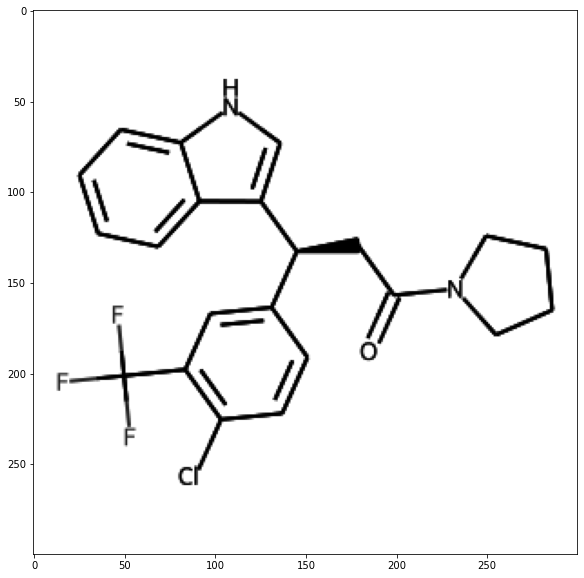

In [132]:
plt.figure(figsize=(10, 10))
plt.imshow(img.prod(axis=-1), cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


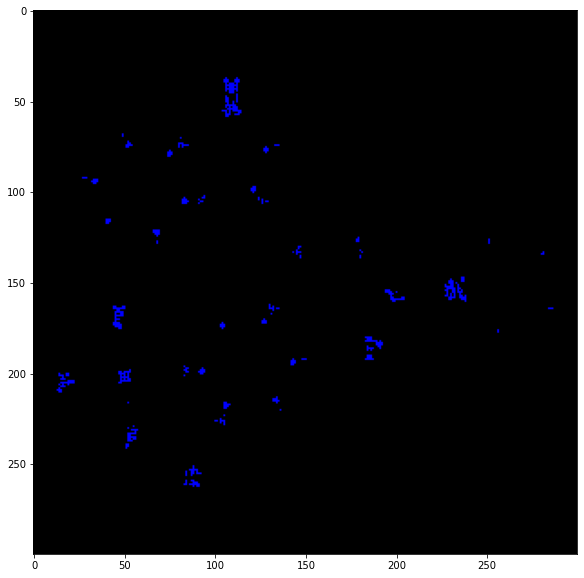

In [143]:
img = plt.imread("test.png")
gray = img.prod(axis=-1)
gray = (gray*255).astype(np.uint8)
gray = cv2.GaussianBlur(gray,(3,3),0)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
# dst = cv2.dilate(dst,None)
img *= 0.
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


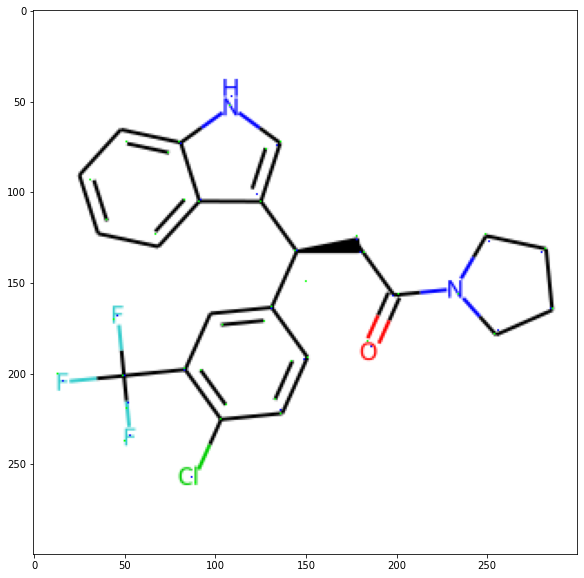

In [160]:
img = plt.imread("test.png")
gray = img.prod(axis=-1)
gray = (gray*255).astype(np.uint8)
gray = cv2.GaussianBlur(gray,(3,3),0)

# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
# img *= 0.
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')